data: [NLP Dataset for Text Analysis​](https://www.kaggle.com/datasets/yashdogra/nlpdataset)  <br>
자연어 데이터 증강, SVC, DistilBert

In [1]:
import pandas as pd
import random
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import wordnet
import numpy as np
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import torch
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ubuntu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
data_path = '/hdd/data/adp_data/nlpdataset/labelled sentences.csv'

df = pd.read_csv(data_path, encoding = 'latin1')
df.head()

,Sentences,Label
0,UN Humanitarian Chief Mark Lowcock today relea...,1
1,The announcement came as the World Health Orga...,0
2,The WHO has said there is still a chance of co...,1
3,"There are now cases linked to Iran in Bahrain,...",1
4,Extensive testing in clinical trials has confi...,1


In [3]:
df['Label'].value_counts()

Label
1    514
0    175
Name: count, dtype: int64

레벨이 0인 데이터들에 Argumentation을 적용하기로 함.

In [4]:
def synonym_replacement(sentence, n = 1):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    for random_word in random_word_list:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        if num_replaced >= n:
            break
    return ' '.join(new_words)

def random_insertion(sentence, n = 1):
    words = sentence.split()
    for _ in range(n):
        new_word = get_random_synonym(words)
        if new_word:
            insert_idx = random.randint(0, len(words))
            words.insert(insert_idx, new_word)
    return ' '.join(words)

def random_swap(sentence, n = 1):
    words = sentence.split()
    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]
    return ' '.join(words)

def random_deletion(sentence, p = 0.1):
    words = sentence.split()
    if len(words) == 1:
        return sentence
    new_words = [word for word in words if random.random() > p]
    return ' '.join(new_words) if new_words else random.choice(words)

def get_random_synonym(words):
    random_word = random.choice(words)
    synonyms = wordnet.synsets(random_word)
    if synonyms:
        return synonyms[0].lemmas()[0].name()
    return None

In [5]:
label_0_df = df[df['Label'] == 0].reset_index(drop = True)

split_indices = np.array_split(label_0_df.index, 4)

augmented_sentences = []

for i, indices in enumerate(split_indices):
    sentences = label_0_df.loc[indices, 'Sentences']
    if i == 0:
        augmented_sentences += [synonym_replacement(s) for s in sentences]
    elif i == 1:
        augmented_sentences += [random_insertion(s) for s in sentences]
    elif i == 2:
        augmented_sentences += [random_swap(s) for s in sentences]
    else:
        augmented_sentences += [random_deletion(s) for s in sentences]

augmented_df = pd.DataFrame({
    'Sentences': augmented_sentences,
    'Label': 0
})

balanced_df = pd.concat([df, augmented_df]).reset_index(drop = True)
balanced_df['Label'].value_counts()

Label
1    514
0    350
Name: count, dtype: int64

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df['Sentences'], df['Label'], test_size = 0.1, random_state = 526)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(620,) (69,)
(620,) (69,)


In [7]:
model_name = 'distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(model_name)
model = DistilBertModel.from_pretrained(model_name)
model.eval()

def get_cls_embeddings(sentences, model, tokenizer):
    embeddings = []
    with torch.no_grad():
        for sent in sentences:
            inputs = tokenizer(sent, return_tensors = 'pt', truncation = True, padding = True, max_length = 128)
            outputs = model(**inputs)
            cls_vec = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
            embeddings.append(cls_vec)
    return embeddings

X_train_emb = get_cls_embeddings(X_train, model, tokenizer)

scaler = StandardScaler()
X_train_emb_scaled = scaler.fit_transform(X_train_emb)

clf = SVC(class_weight = 'balanced')
clf.fit(X_train_emb_scaled, y_train)

SVC(class_weight='balanced')

In [8]:
X_test_emb = get_cls_embeddings(X_test, model, tokenizer)
X_test_emb_scaled = scaler.transform(X_test_emb)
y_pred_svm = clf.predict(X_test_emb_scaled)

cm_svm = confusion_matrix(y_test, y_pred_svm)

y_score_svm = clf.decision_function(X_test_emb_scaled)
fpr_svm, tpr_svm, _ = roc_curve(y_test, y_score_svm)
auc_svm = roc_auc_score(y_test, y_score_svm)

In [9]:
sentence = df['Sentences'].iloc[432]

encoded  = tokenizer.encode(sentence, truncation = True, padding = True)
tokens = tokenizer.convert_ids_to_tokens(encoded)
print(f'Tokenized sentence: {encoded}')
print(f'Tokens: {tokens}')
print(f'Number of tokens: {len(encoded)}')

Tokenized sentence: [101, 1996, 2193, 1997, 3679, 2047, 3572, 9053, 2038, 3333, 12099, 2058, 1996, 2197, 2416, 3134, 1010, 1998, 2062, 2111, 2024, 2108, 12436, 14693, 23854, 1012, 102]
Tokens: ['[CLS]', 'the', 'number', 'of', 'daily', 'new', 'cases', 'nationwide', 'has', 'dropped', 'dramatically', 'over', 'the', 'last', 'six', 'weeks', ',', 'and', 'more', 'people', 'are', 'being', 'va', '##cci', '##nated', '.', '[SEP]']
Number of tokens: 27


In [10]:
model = DistilBertForSequenceClassification.from_pretrained(model_name, num_labels = 2)

def encode_sentences(sentences, tokenizer):
    encodings = tokenizer(sentences, truncation = True, padding = True, return_tensors = 'pt', max_length = 128)
    return encodings

train_encodings = encode_sentences(X_train.tolist(), tokenizer)
test_encodings = encode_sentences(X_test.tolist(), tokenizer)

train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(y_train.values))
test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], torch.tensor(y_test.values))

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size)

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

epochs = 3
for epoch in range(epochs):
    model.train()
    for batch in tqdm(train_dataloader, desc = f'Epoch {epoch + 1} / {epochs}', leave = True):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        optimizer.zero_grad()

        outputs = model(input_ids = input_ids, attention_mask = attention_mask, labels = labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
    
    print(f'Epoch {epoch + 1} / {epochs} - Loss: {loss.item()}')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 / 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 / 3 - Loss: 0.5625764727592468


Epoch 2 / 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 2 / 3 - Loss: 0.5364953875541687


Epoch 3 / 3:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 3 / 3 - Loss: 0.36265257000923157


In [11]:
model.eval()
y_pred_bert = []
y_score_bert = []
with torch.no_grad():
    for batch in tqdm(test_dataloader, leave = True):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]
        outputs = model(input_ids = input_ids, attention_mask = attention_mask)
        logits = outputs.logits

        scores = torch.softmax(logits, dim = -1)[:, 1]
        predictions = torch.argmax(logits, dim = -1)

        y_pred_bert.extend(predictions.cpu().numpy())
        y_score_bert.extend(scores.cpu().numpy())

cm_bert = confusion_matrix(y_test, y_pred_bert)

fpr_bert, tpr_bert, _ = roc_curve(y_test, y_score_bert)
auc_bert = roc_auc_score(y_test, y_score_bert)

  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
print('SVM Confusion Matrix:\n', cm_svm)
print('\nSVM Classification Report:\n', classification_report(y_test, y_pred_svm))

SVM Confusion Matrix:
 [[11  6]
 [ 4 48]]

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.65      0.69        17
           1       0.89      0.92      0.91        52

    accuracy                           0.86        69
   macro avg       0.81      0.79      0.80        69
weighted avg       0.85      0.86      0.85        69



In [13]:
print('DistilBERT Confusion Matrix:\n', cm_bert)
print('\nDistilBERT Classification Report\n', classification_report(y_test, y_pred_bert))

DistilBERT Confusion Matrix:
 [[13  4]
 [ 5 47]]

DistilBERT Classification Report
               precision    recall  f1-score   support

           0       0.72      0.76      0.74        17
           1       0.92      0.90      0.91        52

    accuracy                           0.87        69
   macro avg       0.82      0.83      0.83        69
weighted avg       0.87      0.87      0.87        69



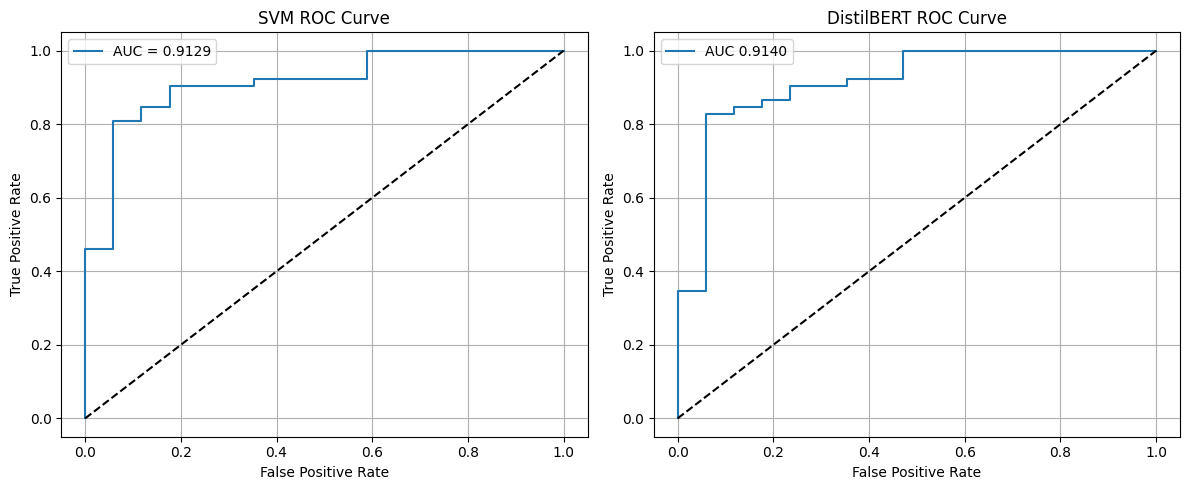

In [14]:
fig, axs = plt.subplots(1, 2, figsize = (12, 5))

axs[0].plot(fpr_svm, tpr_svm, label = f'AUC = {auc_svm:.4f}')
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_title('SVM ROC Curve')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_ylabel('True Positive Rate')
axs[0].legend()
axs[0].grid()

axs[1].plot(fpr_bert, tpr_bert, label = f'AUC {auc_bert:.4f}')
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_title('DistilBERT ROC Curve')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].legend()
axs[1].grid()

plt.tight_layout()
plt.show()